In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from glob import glob
import torch
import os
import sys
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
data_path_folder = "data-20230722"
data = []
labels = []
for filename in glob(data_path_folder + "/*"):
    if not filename.endswith(".csv"):
        continue
    with open(os.path.join(filename), 'r') as f:
        lines = f.readlines()
        sample_data = [[[float(line) for line in lines]]]
        data.append(sample_data)
        label_str = filename.split('/')[1].split('-')[0]
        label = 1 if label_str == "pca" else 0
        labels.append(label)
        
for i in range(len(data)):
    data[i] = torch.tensor(data[i])
    labels[i] = torch.tensor(labels[i])

In [3]:
print(len(data), len(data[0][0]), len(labels))
# print(labels)

33 1 33


In [27]:
data[0]

tensor([[0.0361, 0.0330, 0.0302, 0.0333, 0.0297, 0.0383, 0.0438, 0.0600, 0.0604,
         0.0728, 0.0794, 0.0811, 0.0797, 0.0775, 0.0800, 0.0788, 0.0718, 0.0750,
         0.0773, 0.0781, 0.0810, 0.0827, 0.0854, 0.0868, 0.0906, 0.0922, 0.0921,
         0.0903, 0.0903, 0.0923, 0.0819, 0.0868, 0.0808, 0.0755, 0.0829, 0.0838,
         0.0812, 0.0879, 0.0865, 0.0950, 0.0988, 0.1002, 0.1004, 0.1053, 0.1004,
         0.0945, 0.0840, 0.0824, 0.0819, 0.0759, 0.0753, 0.0686, 0.0658, 0.0633,
         0.0643, 0.0693, 0.0654, 0.0701, 0.0861, 0.0922, 0.1068, 0.1284, 0.1522,
         0.1643, 0.1678, 0.1509, 0.1418, 0.1223, 0.1028, 0.0932, 0.0902, 0.0829,
         0.0883, 0.0948, 0.0863, 0.0815, 0.0710, 0.0629, 0.0522, 0.0435, 0.0405,
         0.0312, 0.0282, 0.0296, 0.0258, 0.0194, 0.0293, 0.0310, 0.0300, 0.0314,
         0.0311, 0.0322, 0.0357, 0.0381, 0.0435, 0.0476, 0.0611, 0.0677, 0.0744,
         0.0880, 0.0939, 0.0973, 0.1118, 0.1150, 0.1232, 0.1279, 0.1346, 0.1297,
         0.1356, 0.1388, 0.1

#### Split the data: Split the data into training and testing sets using the torch.utils.data.Dataset and torch.utils.data.DataLoader classes. \n Here, we have defined a custom dataset class and split the data into training and testing sets. We have also defined data loaders for each set.

In [4]:
from torch.utils.data import Dataset, DataLoader

batchsize = 3
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


train_size = 30
test_size = 21

dataset = MyDataset(data, labels)
train_dataset, _ = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
dataset = MyDataset(data, labels)
_, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [126]:
test_dataset.dataset.data

[tensor([[[[0.0342, 0.0434, 0.0444,  ..., 0.0702, 0.0761, 0.0843]]],
 
 
         [[[0.0218, 0.0289, 0.0297,  ..., 0.0253, 0.0171, 0.0133]]],
 
 
         [[[0.0045, 0.0126, 0.0087,  ..., 0.0132, 0.0076, 0.0056]]]]),
 tensor([0, 1, 1])]

In [98]:
test_loader

In [96]:
type(dataset), type(train_dataset)

(__main__.MyDataset, torch.utils.data.dataset.Subset)

In [61]:
# channel, height, width
data[0].shape

torch.Size([1, 1, 669])

In [5]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.fc1 = nn.Linear(in_features=32*1*167, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 32*1*167)
#         print(x.shape)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
import torch.optim as optim

net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

accuracy_stat = []

for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 10))
            train_loss = running_loss
            running_loss = 0.0

            correct = 0
            total = 0
            with torch.no_grad():
                for data in train_loader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            train_accuracy = correct / total
            
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            test_accuracy = correct / total
#             print(epoch, train_loss, train_accuracy, test_accuracy)
            accuracy_stat.append([epoch, train_loss, train_accuracy, test_accuracy])

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
#         print(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 66 %


In [30]:
accuracy_stat

[[0, 18.052726447582245, 0.6333333333333333, 0.6190476190476191],
 [1, 12.242389291524887, 0.6333333333333333, 0.6190476190476191],
 [2, 10.769436106085777, 0.6333333333333333, 0.6190476190476191],
 [3, 9.455212622880936, 0.6333333333333333, 0.6190476190476191],
 [4, 7.032003194093704, 0.6333333333333333, 0.6190476190476191],
 [5, 8.057922899723053, 0.36666666666666664, 0.38095238095238093],
 [6, 9.04479867219925, 0.6333333333333333, 0.6190476190476191],
 [7, 7.234708696603775, 0.6333333333333333, 0.6190476190476191],
 [8, 7.089479148387909, 0.6333333333333333, 0.6190476190476191],
 [9, 7.617342889308929, 0.36666666666666664, 0.38095238095238093],
 [10, 7.5228045880794525, 0.6333333333333333, 0.6190476190476191],
 [11, 6.854317381978035, 0.6333333333333333, 0.6190476190476191],
 [12, 7.1786856055259705, 0.7, 0.6666666666666666],
 [13, 7.472682356834412, 0.6333333333333333, 0.6190476190476191],
 [14, 6.734460532665253, 0.6333333333333333, 0.6190476190476191],
 [15, 6.693469047546387, 0.

In [18]:
import pandas as pd
acc_df = pd.DataFrame(accuracy_stat, columns=['epoch', 'train_loss', 'train_accuracy', 'test_accuracy'])

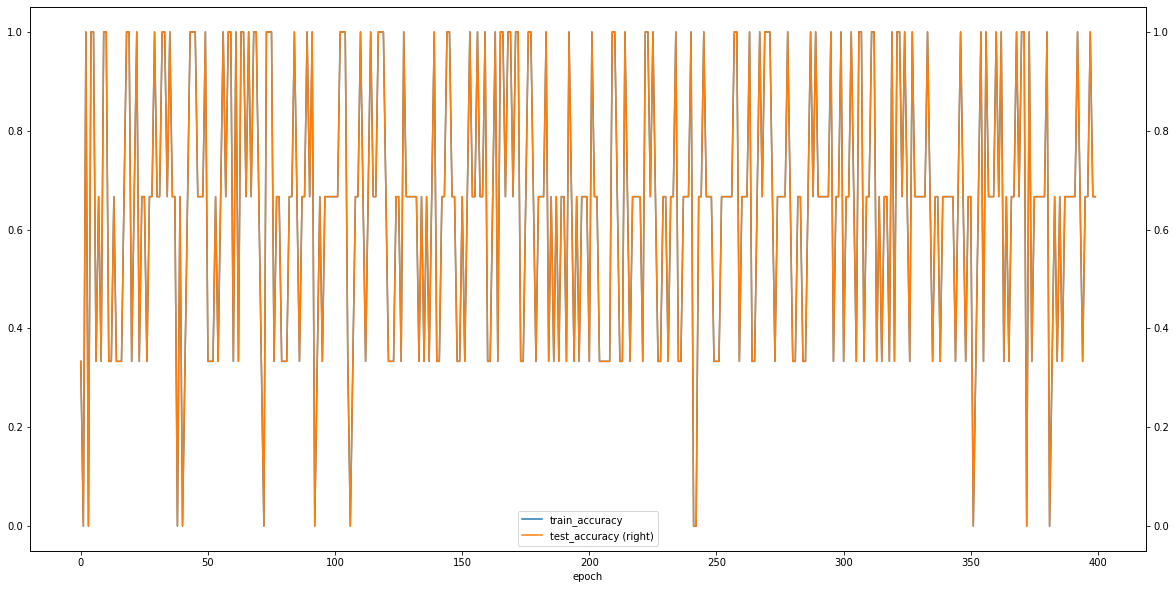

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10)) 
acc_df.plot(x = 'epoch', y = 'train_loss', ax = ax)
# acc_df.plot(x = 'epoch', y = 'train_accuracy', ax = ax)
# acc_df.plot(x = 'epoch', y = 'test_accuracy', ax = ax, secondary_y = True) 